In [18]:
import pandas as pd
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import math
import matplotlib.ticker as mtick
from matplotlib.ticker import FuncFormatter
from shapely.geometry import Point
import geopandas
from geopandas import GeoDataFrame

In [19]:
pd.options.mode.chained_assignment = None 

Olist, found in 2014, is the largest department store in Brazilian marketplaces. Olist connects small businesses from all over Brazil to channels without hassle and with a single contract. Those merchants are able to sell their products through the Olist Store and ship them directly to the customers using Olist logistics partners.

After a customer purchases the product from Olist Store a seller gets notified to fulfill that order. Once the customer receives the product, or the estimated delivery date is due, the customer gets a satisfaction survey by email where he can give a note for the purchase experience and write down some comments.

In [20]:
# 1. Read cleaned datasets
orders = pd.read_csv('orders.csv')
delivered_orders = pd.read_csv('delivered_orders.csv')

print('Len of orders: ', len(orders))
print('Len of delivered_orders: ', len(delivered_orders))

Len of orders:  113425
Len of delivered_orders:  110197


In [21]:
# Convert fields into DateTime Type
def convert_to_datetime(df, fields):
    for field in fields:
        df[field] = pd.to_datetime(df[field])

# Generate needed DateTime related Fields
def generate_purchase_datetime_fields(df):
    df['purchase_date'] = df['order_purchase_timestamp'].dt.date
    df['purchase_year'] = df['order_purchase_timestamp'].dt.year
    df['purchase_month'] = df['order_purchase_timestamp'].dt.month
    df['purchase_weekday_int'] = df['order_purchase_timestamp'].dt.weekday
    df['purchase_hour'] = df['order_purchase_timestamp'].dt.hour
    df['purchase_time_period'] = df['purchase_hour'].apply(lambda x: 'Morning' if x < 12 else 'Afternoon' if x < 18 else 'Evening' if x < 21 else 'Night')
    df['purchase_weekday'] = df['order_purchase_timestamp'].dt.day_name()
    df['purchase_yearmonth'] = pd.to_datetime(df['order_purchase_timestamp']).dt.to_period('M').dt.to_timestamp()
    
datetime_fields = ['order_purchase_timestamp',
                    'order_approved_at', 
                    'order_delivered_carrier_date',
                    'order_delivered_customer_date',
                    'order_estimated_delivery_date']

# Apply for 'orders'
convert_to_datetime(orders, datetime_fields)
generate_purchase_datetime_fields(orders)

# Apply for 'delivered_orders'
datetime_fields = datetime_fields + ['shipping_limit_date']
convert_to_datetime(delivered_orders, datetime_fields)
generate_purchase_datetime_fields(delivered_orders)

# 2. Analysis

## 2.1 Overview of Performance

### 2.1.1 Demand

Text(0.5, 1.0, 'Total Demand/Requested Orders per Purchase Date')

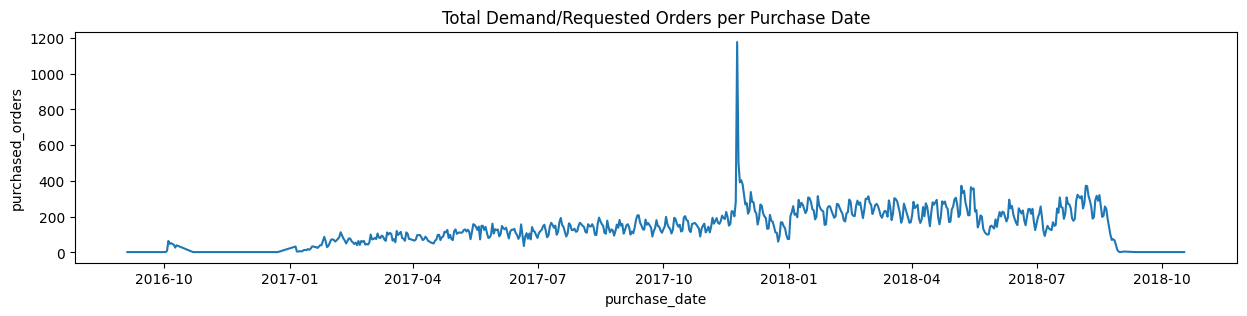

In [74]:
purchased_plot = orders.groupby(['purchase_date'])['order_id'].nunique() \
                        .reset_index() \
                        .rename(columns={'order_id': 'purchased_orders'})

fig, ax = plt.subplots(figsize=(15,3))
sns.lineplot(x='purchase_date', y='purchased_orders', data = purchased_plot, sort=True)
ax.set_title('Total Demand/Requested Orders per Purchase Date')

The demand was quite low at the end of 2016. Then 2017 it started to increase with seasonality until 2018-09. From 2018-09, it decreased and went flat.

There is a suddenly peak at 2017-11, which didn't happend in 2016-11. Let's take a look at those special days.

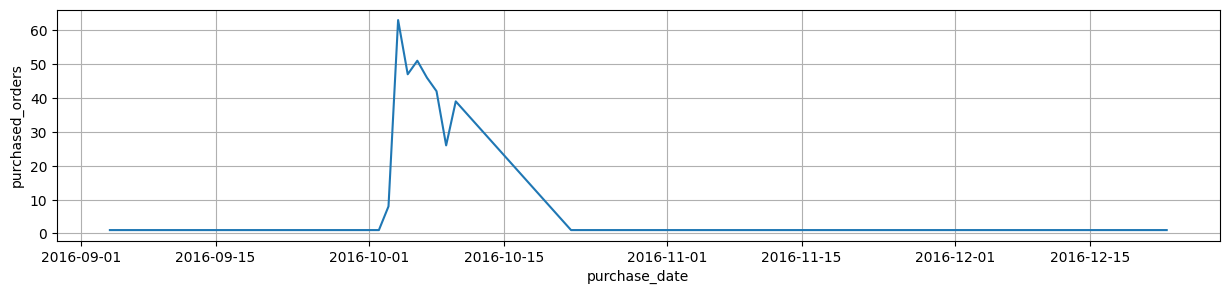

In [36]:
special_dates = purchased_plot[(purchased_plot['purchase_date'] < pd.Timestamp('2017-01-01'))]

fig, ax = plt.subplots(figsize=(15,3))
sns.lineplot(x='purchase_date', y='purchased_orders', data = special_dates, sort=True)
plt.grid()

In 2016, there was very few orders. Olist was founded in 2014, which means it was 2 years but the demand is still very low 

=> Question: noise data or actual low orders?

In [37]:
purchased_plot[purchased_plot['purchased_orders'] == purchased_plot['purchased_orders'].max()]

,purchase_date,purchased_orders
338,2017-11-24,1176


=> Google a little bit, we can know that 2017-11-24 is a Black Friday!!!

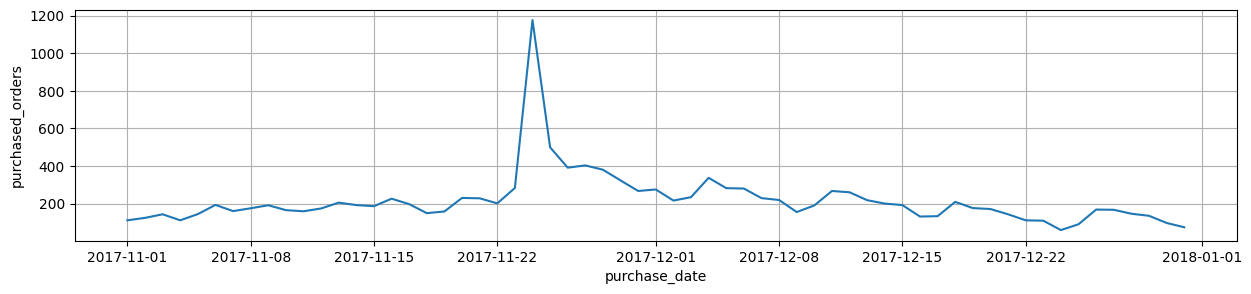

In [38]:
special_dates = purchased_plot[(purchased_plot['purchase_date'] >= pd.Timestamp('2017-11-01')) & \
                (purchased_plot['purchase_date'] < pd.Timestamp('2018-01-01'))]

fig, ax = plt.subplots(figsize=(15,3))
sns.lineplot(x='purchase_date', y='purchased_orders', data = special_dates, sort=True)
plt.grid()

=> Before Black Friday 2017, the demand is still very flat.

=> After a surge increase of Black Friday, the demand decreased from 1200 orders/day to 500 orders/day, and then gradually decreased but still higher than the purchase_month of before Black Friday. And after 2017-12-15, the demand comeback to normal.

Let's take a look at the number of orders per Purchase Status to see how we fulfill those demand!

In [39]:
orders['order_status'].unique()

array(['delivered', 'invoiced', 'shipped', 'processing', 'unavailable',
       'canceled', 'created', 'approved'], dtype=object)

In [40]:
# Absolute Numbers of Orders per Purchase_status
stat_1 = orders.pivot_table(index='purchase_year', columns = 'order_status', 
                            values = 'order_id', aggfunc= 'nunique',
                            fill_value=0, margins=True) 
stat_1 = stat_1.filter(['created', 'approved', 'invoiced', 'processing', 'shipped', 'delivered', 'unavailable', 'canceled', 'All'], axis=1)
for i in stat_1.columns:
    stat_1[i] = stat_1[i].astype(int)

# Percentage Numbers of Orders per Purchase_status
stat_2 = stat_1.div( stat_1.iloc[:,-1], axis=0 )
stat_2 = stat_2.apply(lambda x: round(x, 2)*100)

Text(0.5, 1.0, 'Number of Orders per Purchase Status')

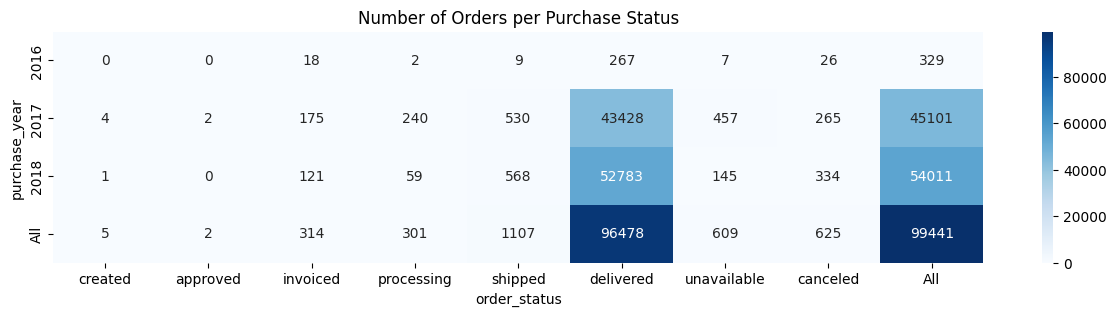

In [41]:
# present data to heatmap:
fig, ax = plt.subplots(figsize=(15,3))
ax = sns.heatmap(data=stat_1, cmap='Blues',
                annot=True, fmt='d');
ax.set_title("Number of Orders per Purchase Status")


Text(0.5, 1.0, 'Percentage of Orders by Purchase Status')

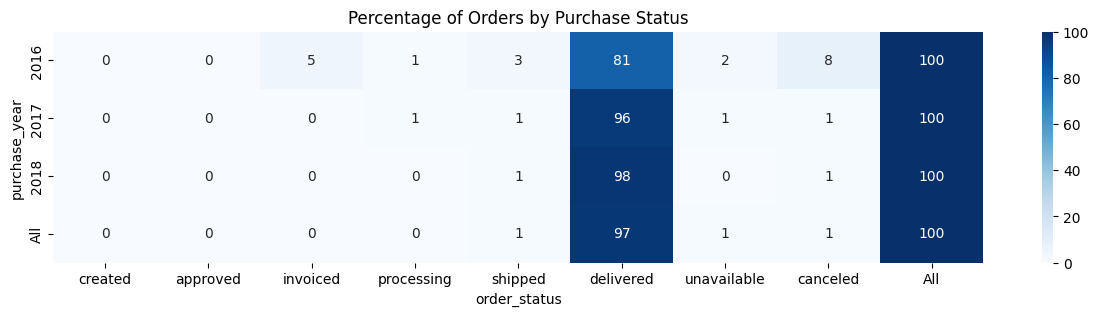

In [42]:
# present data to heatmap:
fig, ax = plt.subplots(figsize=(15,3))
ax = sns.heatmap(data=stat_2, cmap='Blues',
                annot=True, fmt='g');
ax.set_title("Percentage of Orders by Purchase Status")


Cancelled Rate: 
- Cancelled Rate shows the percentage of cancelled orders in our all purchase demands. This metric shows us the percentage of demands that we have goods/freights but cannot successfully fulfill them.
- average is 1%. 
- CR decreased from 8% in 2016 to 1% in 2017 and 2018 => improvement

Unavailable Rate: 
- Unvailable Rate shows the percentage of unavailable orders in our all purchase demands. This metric shows us the percentage of demand we cannot manage to have goods/freights from sellers.
- average is 1%
- UR decreased from 2% in 2016 to 1% in 2017 and 0% in 2018 => improvement

Delivered Rate (Fulfillment Rate): 
- Fulfillment Rate shows the percentage of successful delivered orders in our all purchase demands. This metric shows us the percentage of demand we can fulfill.
- average is 97%. 
- FR increased from 81% in 2016 to 96% in 2017 and 98% in 2018 => improvement

Next, let's look at our mostly orders: DELIVERED ORDERS - to see how well we delivered to our customers.

### 2.1.2 Delivered Orders

Text(0.5, 1.0, 'Total Delivered Orders per Purchase Date')

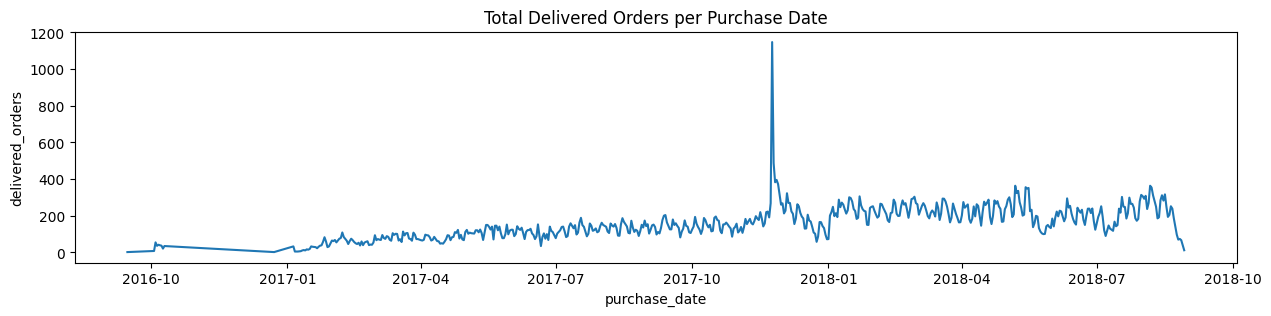

In [72]:
purchased_plot = delivered_orders.groupby(['purchase_date'])['order_id'].nunique() \
                        .reset_index() \
                        .rename(columns={'order_id': 'delivered_orders'})

fig, ax = plt.subplots(figsize=(15,3))
sns.lineplot(x='purchase_date', y='delivered_orders', data = purchased_plot, sort=True)
ax.set_title('Total Delivered Orders per Purchase Date')

order_purchase_timestamp: (2016-09-04, 2018-08-29)

Due to lack of data of 2016 and 2018, to know the growth rate, we can compare the purchase_month:
- first-8-month 2017 and first-8-month 2018

In [82]:
first_8m_2017 = delivered_orders[(delivered_orders['purchase_date'] >= pd.Timestamp('2017-01-01')) & \
                                    (delivered_orders['purchase_date'] < pd.Timestamp('2017-08-30'))]
first_8m_2018 = delivered_orders[(delivered_orders['purchase_date'] >= pd.Timestamp('2018-01-01')) & \
                                    (delivered_orders['purchase_date'] < pd.Timestamp('2018-08-30'))]
order_8m_1718 = first_8m_2017.append(first_8m_2018)

def get_growth_rate(df, value, value_col):
    if value == 'orders':
        stat = df.groupby(['purchase_year'])[value_col].nunique().reset_index(name=value)
    else:
        stat = df.groupby(['purchase_year'])[value_col].sum().reset_index(name=value)
    stat['prev'] = stat[value].shift(1)
    stat['growth_rate'] = stat[value]/stat['prev']*100
    stat['purchase_year'] = stat['purchase_year'].astype('str')
    return stat

compare_order_gr = get_growth_rate(order_8m_1718, 'orders', 'order_id')
compare_gmv_gr = get_growth_rate(order_8m_1718, 'GMV', 'price')

In [45]:
# Number of Orders per Month
orders_per_year_month = order_8m_1718.groupby(['purchase_month', 'purchase_year'])['order_id'].nunique().reset_index(name='orders')
orders_per_year_month['purchase_month'] = orders_per_year_month['purchase_month'].astype('str')

# GROWTH RATE of Orders over Month
orders_per_year_month_ = orders_per_year_month.pivot_table(index='purchase_month', columns='purchase_year', values='orders') \
                    .rename_axis(None, axis=1).reset_index()

orders_per_year_month_['growth_rate'] = (orders_per_year_month_[2018] - orders_per_year_month_[2017]) / orders_per_year_month_[2017] * 100
orders_per_year_month_['purchase_month'] = orders_per_year_month_['purchase_month'].astype('str')

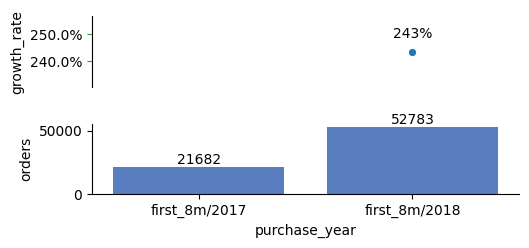

In [108]:
def plot_growth_rate(figsize, df, df2, X, Y, list_xticklabels = None, hue=None):
    fig, axes = plt.subplots(figsize=figsize, nrows=2, ncols = 1, sharex=True)
    fig.tight_layout()
    plt.subplots_adjust(top=0.9, bottom=0.01)

    #line plot creation
    ax1 = sns.lineplot(ax = axes[0], x=X, y='growth_rate', data = df2, sort=False, marker = 'o')
    ax1.tick_params(axis='y', color='tab:green')
    ax1.yaxis.set_major_formatter(mtick.PercentFormatter())
    ax1.get_xaxis().set_visible(False)
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.spines['bottom'].set_visible(False)
    fig.set_transform(ax1.transAxes)

    sns.set_color_codes("muted")
    if hue is None:
        ax2 = sns.barplot(ax = axes[1], x=X,  y=Y, data = df, errorbar=None, color = 'b') # hue = 'has_discount',
    else:
        ax2 = sns.barplot(ax = axes[1], x=X,  y=Y, data = df, errorbar=None, hue = hue)
        ax2.legend(bbox_to_anchor=(1., 1.05))
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    
    if list_xticklabels is not None:
        ax2.set_xticklabels(list_xticklabels)
    

    for x,y in zip(df2[X], df2['growth_rate']):
        label = "{:.0f}%".format(y)
        ax1.annotate(label, # this is the text
                    (x,y), # these are the coordinates to position the label
                    textcoords="offset points", # how to position the text
                    xytext=(0,10), # distance from text to points (x,y)
                    ha='center') # horizontal alignment can be left, right or center

    for container2 in ax2.containers:
        ax2.bar_label(container2, labels=["{:.0f}".format(i) for i in container2.datavalues])

    plt.show()

plot_growth_rate((5,2), compare_order_gr, compare_order_gr, 'purchase_year', 'orders', list_xticklabels = ['first_8m/2017', 'first_8m/2018'])


=> From first_8m/2017 to first_8m/2018, there is 243% of growth rate

=> Olist gained such a rapid growth

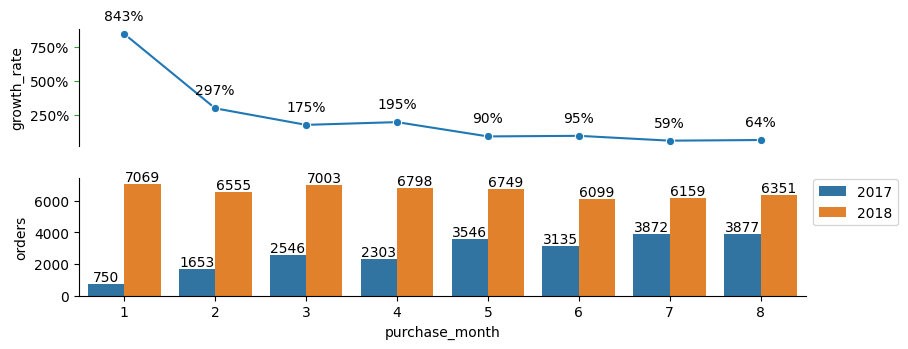

In [109]:
plot_growth_rate((8,3), orders_per_year_month, orders_per_year_month_, 'purchase_month', 'orders',  hue='purchase_year')

Conclusion:

- Olist growed very fast YoY and could get peak at special day like Black Friday.

-> This requires Olist to care more about the delivery performance, the inventory management, especially for special days

### 2.1.3 GMV

Gross Merchandise Value (GMV) : 

An important figure in e-commerce, it shows the value of merchandise sold (and delivered) less returns and not including shipping costs. The GMV is an indicator of the sale performance of the e-commerce site and is an indicator of the revenue of the site.

In [118]:
def millions(x, pos):
    'The two args are the value and tick position'
    return '%1.1fM' % (x * 1e-6)
formatter = FuncFormatter(millions)

In [171]:
round(delivered_orders['price'].sum())

13221498

=> Total GMV from T09/2016 - T08/2018 is 13,221,498

In [173]:
# calculate GMV per day
gmv_per_day = delivered_orders.groupby(['purchase_date'])['price'].sum().reset_index(name='GMV')

# calculate GMV per month
gmv_per_month = delivered_orders.groupby(['purchase_year','purchase_yearmonth'])['price'].sum().reset_index(name='GMV')

# calculate GMV per year
gmv_per_year = delivered_orders.groupby(['purchase_year'])['price'].sum().reset_index(name='GMV')
min_purchase_date = delivered_orders.groupby(['purchase_year'])['purchase_date'].min().reset_index(name='min_purchase_date')
max_purchase_date = delivered_orders.groupby(['purchase_year'])['purchase_date'].max().reset_index(name='max_purchase_date')
gmv_per_year = gmv_per_year.merge(min_purchase_date, on='purchase_year', how='left').merge(max_purchase_date, on='purchase_year', how='left')

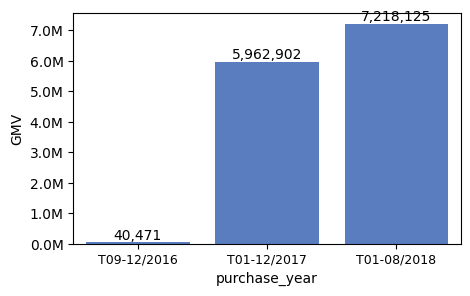

In [130]:
fig, ax = plt.subplots(figsize=(5,3))
ax = sns.barplot(x='purchase_year',  y='GMV', data = gmv_per_year, errorbar=None, color = 'b')
ax.yaxis.set_major_formatter(formatter)
ax.xaxis.set_tick_params(labelsize=9)

for container in ax.containers:
        ax.bar_label(container, labels=[f'{x:,.0f}' for x in container.datavalues])

ax.set_xticklabels(['T09-12/2016', 'T01-12/2017', 'T01-08/2018'])
plt.show()

- Total GMV of 2017 was 5.96M
- Total GMV of 01/2018 - 08/2018 was 7.22M, although there was just 8 month, but the total GMV was more than  the whole year of 2017.

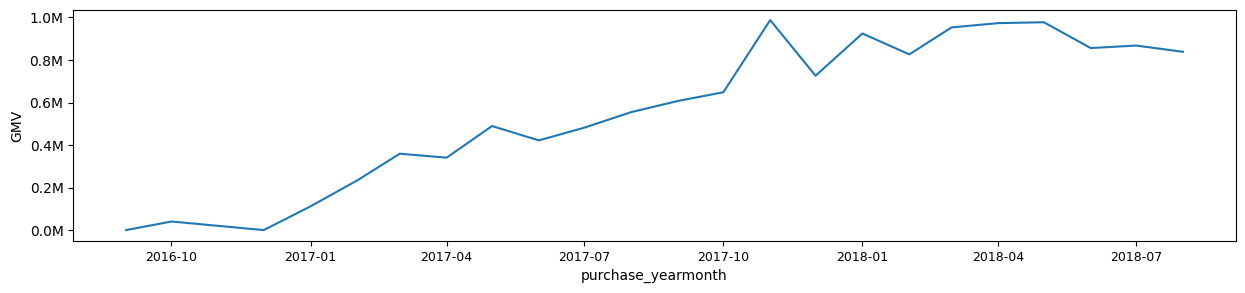

In [174]:
fig, ax = plt.subplots(figsize=(15,3))
ax = sns.lineplot(x='purchase_yearmonth', y='GMV', data = gmv_per_month, sort=True)
ax.yaxis.set_major_formatter(formatter)
ax.xaxis.set_tick_params(labelsize=9)


peak = 'Peak of Revenue'
ax.annotate(peak, 
            xy=(1,1),
            xytext=(2,2),fontsize=15, color='red',
            arrowprops=dict(facecolor='#FC5190',shrink=0.05),
            horizontalalignment='left', verticalalignment='top')

# plt.grid()
plt.show()

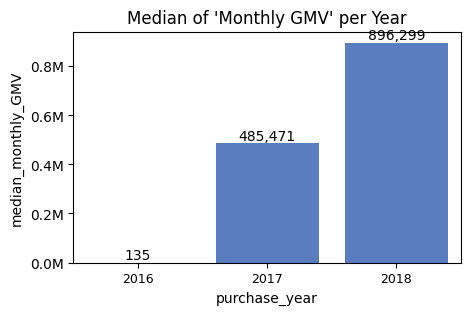

In [184]:
median_monthly_GMV = gmv_per_month.groupby(['purchase_year'])['GMV'].median().reset_index(name='median_monthly_GMV')

fig, ax = plt.subplots(figsize=(5,3))
ax = sns.barplot(x='purchase_year',  y='median_monthly_GMV', data = median_monthly_GMV, errorbar=None, color = 'b')
ax.yaxis.set_major_formatter(formatter)
ax.xaxis.set_tick_params(labelsize=9)

for container in ax.containers:
        ax.bar_label(container, labels=[f'{x:,.0f}' for x in container.datavalues])

ax.set_title("Median of 'Monthly GMV' per Year")
plt.show()

Conclusion:

- GMV of Nov-2017 has the peak.
- Monthly GMV of 2018 is <b>double</b> more than 2017 (2017: 485K, 2018: 896K)
- GMV of Olist overall increased over time

### 2.1.4 Average Order Per Day and Average Order Value

Average Order Value (AOV)

Average order value shows the average order value of customers. It is obtained by dividing the GMV by the total number of order during the selected daterange. The AOV is an important indicator as it not only related to the profit margin but also gives an understanding of the users behavior and spending patterns.

In [201]:
orders_per_date = delivered_orders.groupby(['purchase_date'])['order_id'].nunique().reset_index(name='orders')
order_gmv_per_day = orders_per_date.merge(gmv_per_day, on='purchase_date', how='left')
order_gmv_per_day['AOV'] = round(order_gmv_per_day['GMV'] / order_gmv_per_day['orders'])

In [168]:
order_gmv_per_day.describe()

,orders,GMV,AOV
count,612.000000,612.000000,612.000000
mean,157.643791,21603.755082,138.311966
std,89.507146,12316.810305,28.309503
min,1.000000,10.900000,10.900000
25%,97.750000,12822.230000,122.628387
50%,145.500000,20098.560000,134.251784
75%,213.250000,28726.275000,149.109975
max,1147.000000,149916.580000,337.975000


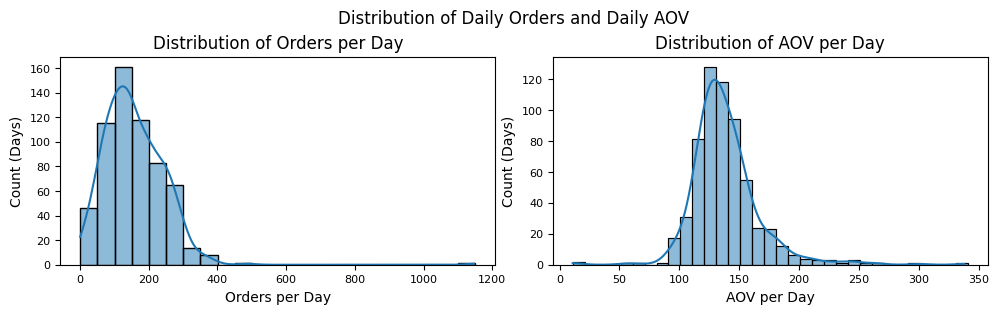

In [187]:
fig, axes = plt.subplots(figsize=(10,3), nrows=1, ncols = 2)
fig.suptitle("Distribution of Daily Orders and Daily AOV")
fig.tight_layout()

ax1 = sns.histplot(ax = axes[0], data=order_gmv_per_day, x="orders", binwidth=50, kde=True)
ax1.set(title='Distribution of Orders per Day',
            ylabel='Count (Days)', 
            xlabel='Orders per Day')
ax1.tick_params(labelsize=8)

ax2 = sns.histplot(ax = axes[1], data=order_gmv_per_day, x="AOV", binwidth=10, kde=True)
ax2.set(title='Distribution of AOV per Day',
            ylabel='Count (Days)', 
            xlabel='AOV per Day')
ax2.tick_params(labelsize=8)

plt.show()


Conclusion:
- In a day, purchased orders could reach to 1200 -> special date
- Mostly, there were about 100-200 orders purchased in a day.
- In a day, Average Order Value could reach $337/order/day.
- Mostly, there was about $120-150 Average Order Value per order per day.


### 2.1.5 Orders Pattern

#### Weekday Type

In [230]:
cond = (delivered_orders['purchase_weekday'] == 'Saturday') | (delivered_orders['purchase_weekday'] == 'Sunday')
delivered_orders['weekday_type'] = np.where(cond, 'Weekend', 'Weekday')

order_gmv_per_day = delivered_orders.groupby(['purchase_date','weekday_type', 'purchase_weekday', 'purchase_weekday_int']) \
                                    .agg({'order_id': 'nunique', 'price': 'sum'}) \
                                    .reset_index() \
                                    .rename(columns={'order_id': 'daily_orders', 'price': 'daily_GMV'})
order_gmv_per_day['daily_AOV'] = round(order_gmv_per_day['daily_GMV'] / order_gmv_per_day['daily_orders'])

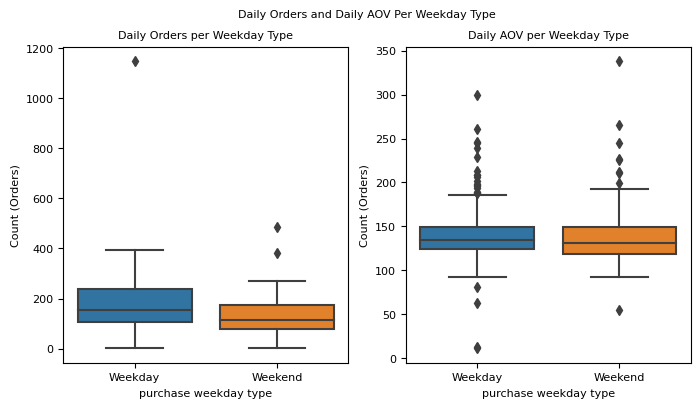

In [555]:
# weekday_type_perf = order_gmv_per_day.groupby(['weekday_type']).agg({'daily_orders': 'median', 
#                                                 'daily_GMV': 'median', 
#                                                 'daily_AOV': 'median'}) \
#                                         .reset_index()

fig, axes = plt.subplots(figsize=(7,4), nrows=1, ncols = 2)
fig.suptitle("Daily Orders and Daily AOV Per Weekday Type", fontsize = 8)
fig.tight_layout()

ax1 = sns.boxplot(ax = axes[0], x= 'weekday_type',  y= 'daily_orders', data = order_gmv_per_day)
ax1.set_title ('Daily Orders per Weekday Type', fontsize = 8)
ax1.set_ylabel('Count (Orders)', fontsize = 8)
ax1.set_xlabel('purchase weekday type', fontsize = 8)
ax1.tick_params(labelsize=8)

ax2 = sns.boxplot(ax = axes[1], x= 'weekday_type',  y= 'daily_AOV', data = order_gmv_per_day)
ax2.set_title('Daily AOV per Weekday Type', fontsize = 8)
ax2.set_ylabel('Count (Orders)', fontsize = 8)
ax2.set_xlabel('purchase weekday type', fontsize = 8)
ax2.tick_params(labelsize=8)

plt.show()


Conclusion:
- Customers tend to place orders in Weekday than Weekend
- There is not a big difference of Daily AOV between Weekday and Weekend -> Hypothesis: Purchase at weekend has higher AOV?

#### Weekday & Hour in a day

In [228]:
order_gmv_per_day

,purchase_date,weekday_type,purchase_weekday,daily_orders,daily_GMV,daily_AOV
0,2016-09-15,Weekday,Thursday,1,134.97,135.0
1,2016-10-03,Weekday,Monday,7,441.98,63.0
2,2016-10-04,Weekday,Tuesday,54,8595.89,159.0
3,2016-10-05,Weekday,Wednesday,35,6169.77,176.0
4,2016-10-06,Weekday,Thursday,41,5889.96,144.0
...,...,...,...,...,...,...
607,2018-08-25,Weekend,Saturday,69,10599.41,154.0
608,2018-08-26,Weekend,Sunday,73,8070.71,111.0
609,2018-08-27,Weekday,Monday,66,5345.91,81.0
610,2018-08-28,Weekday,Tuesday,39,3673.91,94.0


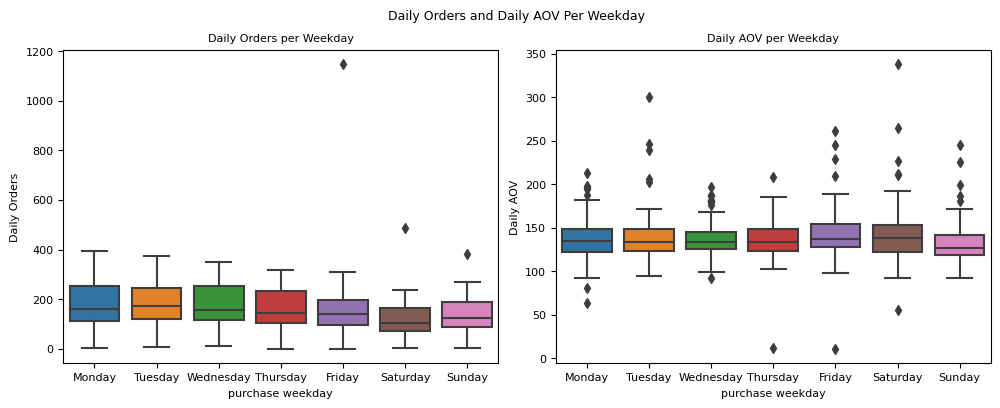

In [316]:
order_gmv_per_day = order_gmv_per_day.sort_values(by=['purchase_weekday_int'])

fig, axes = plt.subplots(figsize=(10,4), nrows=1, ncols = 2)
fig.suptitle("Daily Orders and Daily AOV Per Weekday", fontsize = 9)
fig.tight_layout()

ax1 = sns.boxplot(ax = axes[0], x= 'purchase_weekday',  y= 'daily_orders', data = order_gmv_per_day)
ax1.set_title ('Daily Orders per Weekday', fontsize = 8)
ax1.set_ylabel('Daily Orders', fontsize = 8)
ax1.set_xlabel('purchase weekday', fontsize = 8)
ax1.tick_params(labelsize=8)


ax2 = sns.boxplot(ax = axes[1], x= 'purchase_weekday',  y= 'daily_AOV', data = order_gmv_per_day)
ax2.set_title ('Daily AOV per Weekday', fontsize = 8)
ax2.set_ylabel('Daily AOV', fontsize = 8)
ax2.set_xlabel('purchase weekday', fontsize = 8)
ax2.tick_params(labelsize=8)

plt.show()


Median Number of Daily Orders on Tuesday is the highest.

Whereas, Median number of Daily AOV on Friday is the highest, which means customers often buy high price product on Friday.

Text(0.5, 1.0, 'Median of Daily AOV per Time Period and Weekday')

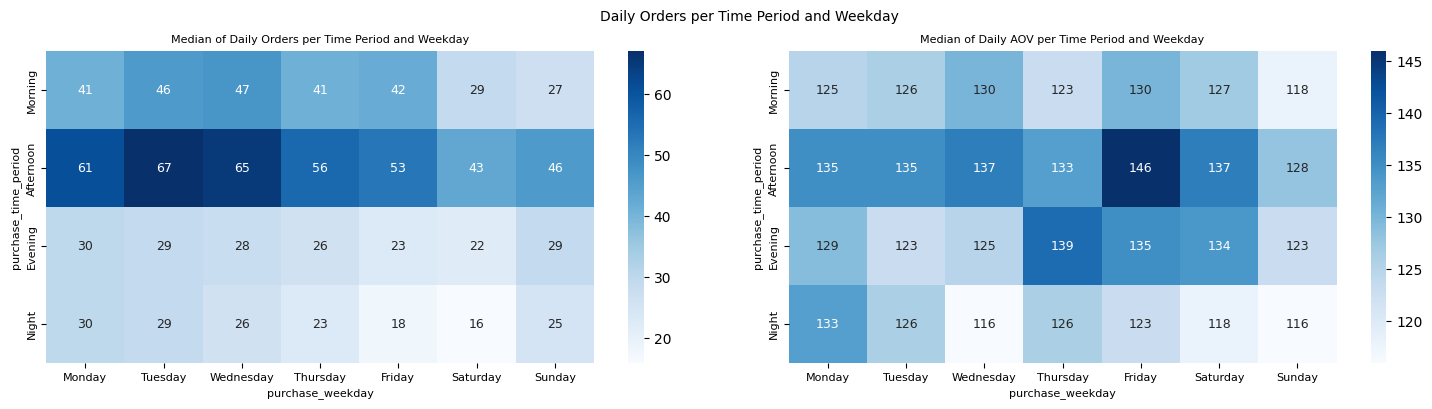

In [369]:

# purchase_time_period

time_period_weekday = delivered_orders.pivot_table(index=['purchase_date', 'purchase_weekday', 'purchase_time_period'], 
                                            # columns='purchase_weekday', 
                                            values=['order_id', 'price'], 
                                            aggfunc={'order_id': 'nunique', 'price': 'sum'}, 
                                            fill_value=0)

time_period_weekday = time_period_weekday.reset_index(level=['purchase_date','purchase_weekday','purchase_time_period'])
time_period_weekday = time_period_weekday.rename(columns={'order_id': 'daily_orders', 'price': 'daily_GMV'})
time_period_weekday["daily_AOV"]=(time_period_weekday["daily_GMV"]/time_period_weekday["daily_orders"])

def get_time_period_data(DF, VALUE):
    DF = DF.pivot_table(index=['purchase_time_period'],
                            columns='purchase_weekday',
                            values= VALUE,
                            aggfunc= 'median')
    weekday = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    time_period = ['Morning', 'Afternoon','Evening','Night']
    DF = DF.reindex(index= time_period)
    DF = DF.filter(weekday, axis = 1)
    for i in  DF.columns:
        DF[i] = DF[i].astype(int)  
    return DF

time_period_weekday_1 = get_time_period_data(time_period_weekday, 'daily_orders')
time_period_weekday_2 = get_time_period_data(time_period_weekday, 'daily_AOV')

# present data to heatmap:
fig, axes = plt.subplots(figsize=(15,4), nrows=1, ncols = 2)
fig.suptitle("Daily Orders per Time Period and Weekday", fontsize = 10)
fig.tight_layout()

ax1 = sns.heatmap(ax = axes[0], data=time_period_weekday_1, cmap='Blues', annot=True, annot_kws={"size":9}, fmt='d');
ax1.xaxis.label.set_size(8)
ax1.yaxis.label.set_size(8)
ax1.tick_params(labelsize=8)
ax1.set_title('Median of Daily Orders per Time Period and Weekday', fontsize = 8)

ax2 = sns.heatmap(ax = axes[1], data=time_period_weekday_2, cmap='Blues', annot=True, annot_kws={"size":9}, fmt='d');
ax2.xaxis.label.set_size(8)
ax2.yaxis.label.set_size(8)
ax2.tick_params(labelsize=8)
ax2.set_title('Median of Daily AOV per Time Period and Weekday', fontsize = 8)

- Afternoon of every weekday has the most Daily Orders (12h-17h), especially Monday to Wednesday (>60 Daily Orders)
- Morning of Monday to Friday also has the second most Daily Orders (0h-12h).
- Afternoon of Friday and Evening of Thursday has the highest Daily AOV, which means customers often buy high price products at this period of time
- Afternoon of every weekday has the most Daily AOV, especially Afternoon of Friday. 

Recommendations:
- Olist can upsell or release new products to increase volume on the Afternoon (12h-17h) from Monday-Friday.
- Olist can display high priced products to make customers spend more on Afternoon Friday and Evening Thursday, for example, holding a Premium Brand Day, Golden Hour...

Text(0.5, 1.0, 'Daily Orders per Hour and Weekday')

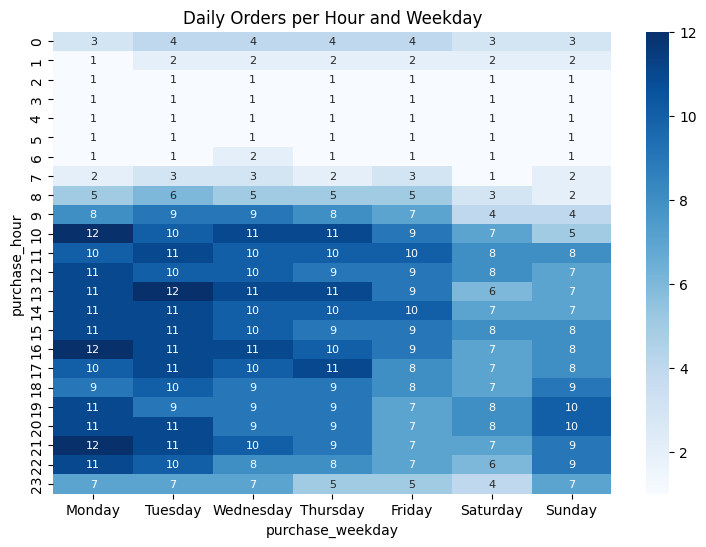

In [370]:
hour_weekday = delivered_orders.pivot_table(index=['purchase_date', 'purchase_weekday', 'purchase_hour'], 
                                            # columns='purchase_weekday', 
                                            values=['order_id', 'price'], 
                                            aggfunc={'order_id': 'nunique', 'price': 'sum'}, 
                                            fill_value=0)
weekday = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
# hour_weekday = hour_weekday.filter(weekday, axis=1)
hour_weekday = hour_weekday.reset_index(level=['purchase_date','purchase_weekday','purchase_hour'])
hour_weekday = hour_weekday.rename(columns={'order_id': 'daily_orders', 'price': 'daily_GMV'})
hour_weekday["daily_AOV"]=(hour_weekday["daily_GMV"]/hour_weekday["daily_orders"])

hour_weekday = hour_weekday.pivot_table(index=['purchase_hour'],
                        columns='purchase_weekday',
                        values='daily_orders',
                        aggfunc= 'median')

hour_weekday = hour_weekday.filter(weekday, axis = 1)               

for i in  hour_weekday.columns:
    hour_weekday[i] = hour_weekday[i].astype(int)  

# present data to heatmap:
fig, ax = plt.subplots(figsize=(9,6))
ax = sns.heatmap(data=hour_weekday, cmap='Blues',
                annot=True, annot_kws={"size":8}, fmt='d');
ax.set_title("Daily Orders per Hour and Weekday")

The most often blocktime that customers often place orders:

- On Monday, hour at 10, 16, 21 has the highest orders, most often period of time is 10-17h, 19-22h.
- On Tuesday, hour at 13 has the highest orders, most often period of time is 10-18h, 20-22h.
- On Wednesday, hour at 10, 13, 16 has the highest orders, most often period is 11-17h.
- On Thursday, hour at 10, 13, 17 has the highest orders, most often period is 10-11h, 13h-14h, 16h-17h.
- On Friday, hour at 11, 14 has the highest orders, most often period is 10-18h.
- On Saturday, hour at 11, 12, 15, 19, 20 has the highest orders, most often period is 10-21h.
- On Sunday, hour at 19, 20 has the highest orders, most often period is 11-22h.

Recommendations: 
- These period of hour can be helpful when promoting products for customers by displaying banners, notifications, flash sales, call to action...

### 2.1.6 Delivery Performance

Delivery Lead Time: From Purchase Date to Deliveried Customer Date
- Show how long does it take for our service to delivery products to customers
- Customers expect this to be very short and can track the delivery progress visibly

Inbound Delivery Days: From Purchase Date to Delivered to Carrier
- Show how long does it take for Sellers to send their products to our Carriers
- Track this metric for improving Seller delivery time further

Outbount Delivery Days: From Delivered to Carrier to Delivered to Customer
- Show how long does it take for Carrier to delivery to customers
- Track this metric for choosing best Carrier and also improving Carrier delivery time further

#### Delivery Lead Time

In [22]:
delivered_orders['delivery_lead_time'] = (delivered_orders['order_delivered_customer_date'] - delivered_orders['order_purchase_timestamp']).dt.days
delivered_orders['inbound_delivery_days'] = (delivered_orders['order_delivered_carrier_date'] - delivered_orders['order_purchase_timestamp']).dt.days
delivered_orders['outbound_delivery_days'] = (delivered_orders['order_delivered_customer_date'] - delivered_orders['order_delivered_carrier_date']).dt.days

delivered_orders['est_vs_customer_days'] = (delivered_orders['order_estimated_delivery_date'] - delivered_orders['order_delivered_customer_date']).dt.days
delivered_orders['limit_vs_carrier_days'] = (delivered_orders['shipping_limit_date'] - delivered_orders['order_delivered_carrier_date']).dt.days

delivered_orders['customer_delivery_perf'] = np.where(delivered_orders['est_vs_customer_days'] > 0, 'Delivery on Time', 'Delivery Late')
delivered_orders['carrier_delivery_perf'] = np.where(delivered_orders['limit_vs_carrier_days'] > 0, 'Delivery on Time', 'Delivery Late')

rmv_dup_orders = delivered_orders.drop_duplicates(['order_id', 'delivery_lead_time'], keep='first')

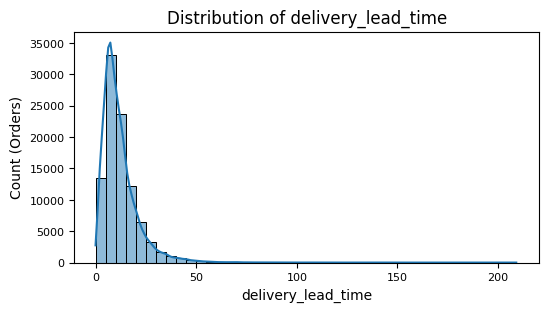

count    96478.000000
mean        12.093555
std          9.551058
min          0.000000
25%          6.000000
50%         10.000000
75%         15.000000
max        209.000000
Name: delivery_lead_time, dtype: float64


In [524]:
def plot_hist_time(df, field, bins):
    plot_df = df[['order_id', field]].drop_duplicates(keep='first')

    fig, ax = plt.subplots(figsize=(6,3))

    ax = sns.histplot(data=plot_df, x= field, binwidth=bins, kde=True)
    ax.set(title='Distribution of {}'.format(field),
                ylabel='Count (Orders)', 
                xlabel= field)
    ax.tick_params(labelsize=8)
    plt.show()
    print(df[field].describe())

plot_hist_time(rmv_dup_orders, 'delivery_lead_time', 5)

- Delivery Lead Time can reach 209 days, which is too long
- Most orders were delivered to customers within 10 days after purchased (6-15 days)


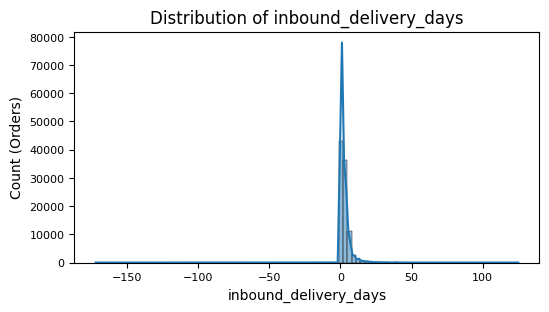

count    96478.000000
mean         2.736375
std          3.611302
min       -172.000000
25%          1.000000
50%          2.000000
75%          4.000000
max        125.000000
Name: inbound_delivery_days, dtype: float64


In [439]:
plot_hist_time(rmv_dup_orders, 'inbound_delivery_days', 3)

- Delivery Inbound Day (Sent to Carrier after purchased)  can reach 125 days
- There are also cases that Delivered to Carrier even before the Purchase Date -> need more sense of business model to analyze this further!
- Most orders were delivered to Carrier after purchased within 1-4 days (2 days on average)

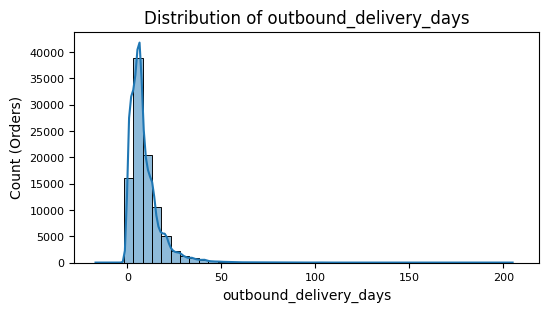

count    96478.000000
mean         8.878459
std          8.746645
min        -17.000000
25%          4.000000
50%          7.000000
75%         12.000000
max        205.000000
Name: outbound_delivery_days, dtype: float64


In [442]:
plot_hist_time(rmv_dup_orders, 'outbound_delivery_days', 5)

- Delivery Outbound Day (Sent to Customers after sending for Carrier) can reach 205 days
- There are also cases that Delivered to Customers even before the Delivered to Carrier Date -> need more sense of business model to analyze this further!
- Most orders were delivered to Customer after sending for Carrier within 4-12 days (7 days on average)

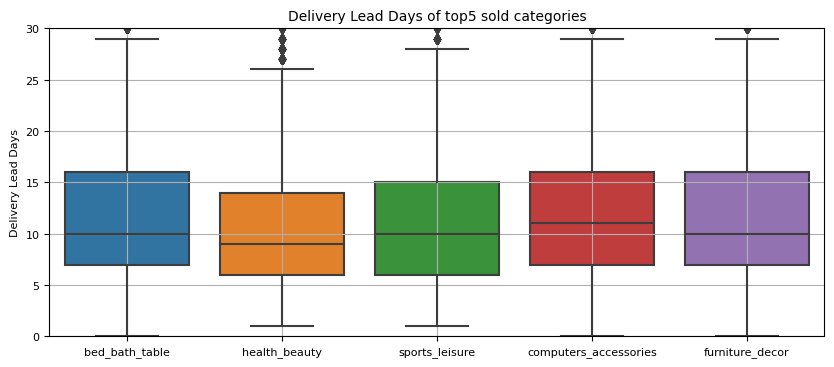

In [539]:
rmv_dup_orders_cat = delivered_orders.groupby(['order_id','product_category_name_english'])['delivery_lead_time'].median().reset_index()


top_sold_cat = rmv_dup_orders_cat.groupby('product_category_name_english')['order_id'].size() \
                                    .sort_values(ascending=False) \
                                    .head(5) \
                                    .reset_index(name='orders') ['product_category_name_english'].to_list()
top_sold_cat_order = rmv_dup_orders_cat[rmv_dup_orders_cat['product_category_name_english'].isin(top_sold_cat)]


fig, ax = plt.subplots(figsize=(10,4))
sns.boxplot(data=top_sold_cat_order, 
            x="product_category_name_english", 
            y="delivery_lead_time",
            order=top_sold_cat)
ax.set_title("Delivery Lead Days of top5 sold categories", fontsize=10)
ax.set_xlabel(None)
ax.set_ylabel('Delivery Lead Days', fontsize=8)
ax.set_ylim(0,30)
ax.tick_params(labelsize=8)
plt.grid()
plt.show()

There is no big difference of Delivery Lead Days between top 5 sold categories (6-16 days)

Conclusion:
- Delivery Lead Days, from after purchased to delivered to customers is 6-15 days (10 days on average).
- Inbound Delivery Lead Days, from after purchased to delivered to carriers, is 1-4 days (2 days on average).
- Outbound Delivery Lead Days, from after delivered to carriers to delivered to customers, is 4-12 days (7 days on average).

##### On Time Commitment

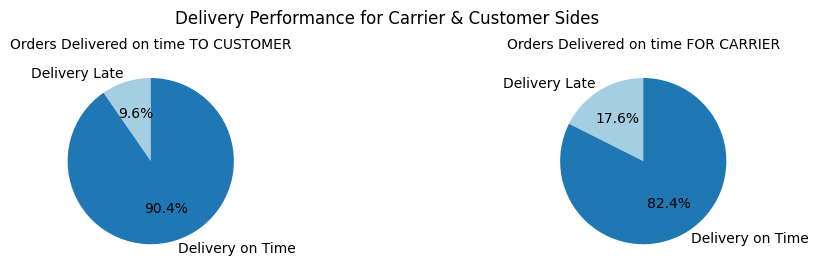

In [540]:
fig, axes = plt.subplots(figsize=(10,3), nrows=1, ncols = 2)
fig.suptitle("Delivery Performance for Carrier & Customer Sides", fontsize = 12)
fig.tight_layout()

plt.rcParams["figure.facecolor"] = "w"
plot_df_1 = delivered_orders.groupby(['customer_delivery_perf'])['order_id'].nunique().sort_values()
plot_df_2 = delivered_orders.groupby(['carrier_delivery_perf'])['order_id'].nunique().sort_values()

# Plot bar chart
ax2 = plot_df_2.plot(ax=axes[1], kind='pie', y='order_id', \
                autopct='%1.1f%%', startangle=90, 
                colors = sns.color_palette('Paired'))
ax2.set_title('Orders Delivered on time FOR CARRIER', fontsize = 10)
ax2.set_ylabel(None)
ax2.tick_params(labelsize=8)

# Plot pie chart
ax1 = plot_df_1.plot(ax=axes[0], kind='pie', y='order_id', \
                autopct='%1.1f%%', startangle=90, 
                colors = sns.color_palette('Paired'))
ax1.set_title('Orders Delivered on time TO CUSTOMER', fontsize = 10)
ax1.set_ylabel(None)
ax1.tick_params(labelsize=8)

plt.show()

- Delivery To Customer On Time Rate: 90.4%, which is good performance -> This rate shows how we successfully commit to our customers about estimate and actual delivery date.
- Delivery For Carrier On Time Rate: 82.4% -> This rate shows how sellers successfully commit to send products/items on time for Carrier to ship.

In [412]:
plot_df_1

customer_delivery_perf
Delivery Late        9288
Delivery on Time    87190
Name: order_id, dtype: int64

In [413]:
plot_df_2

carrier_delivery_perf
Delivery Late       16956
Delivery on Time    79522
Name: order_id, dtype: int64

In [541]:
customer_late_orders = delivered_orders[delivered_orders['customer_delivery_perf'] == 'Delivery Late']
customer_late_orders['est_vs_customer_days'].describe()

count    10324.000000
mean        -8.223847
std         13.164956
min       -189.000000
25%        -10.000000
50%         -4.000000
75%         -1.000000
max          0.000000
Name: est_vs_customer_days, dtype: float64

Most orders are late 1-10 days (late 5 days on average)

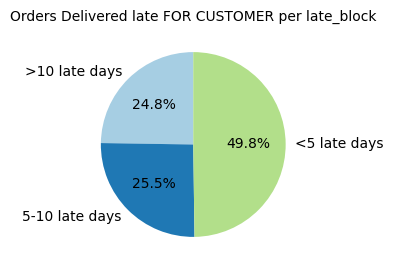

In [542]:
customer_late_orders['late_block'] = customer_late_orders['est_vs_customer_days'].apply(lambda x: '<5 late days' if abs(x) < 5 else '5-10 late days' if abs(x) <= 10 else '>10 late days')
late_block = customer_late_orders.groupby('late_block')['order_id'].nunique().sort_values()

# Plot bar chart
fig, ax = plt.subplots(figsize=(3,3))
ax = late_block.plot(kind='pie', y='order_id', \
                autopct='%1.1f%%', startangle=90, 
                colors = sns.color_palette('Paired'))
ax.set_title('Orders Delivered late FOR CUSTOMER per late_block', fontsize = 10)
ax.set_ylabel(None)
ax.tick_params(labelsize=8)

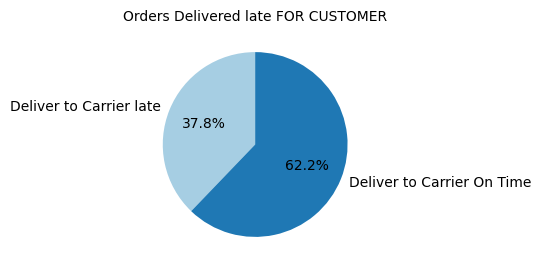

In [543]:
customer_late_orders['carrier_delivery_perf'] = np.where(customer_late_orders['carrier_delivery_perf'] == 'Delivery Late', 'Deliver to Carrier late', 'Deliver to Carrier On Time')
customer_late = customer_late_orders.groupby(['carrier_delivery_perf'])['order_id'].nunique().sort_values()

# Plot bar chart
fig, ax = plt.subplots(figsize=(3,3))
ax = customer_late.plot(kind='pie', y='order_id', \
                autopct='%1.1f%%', startangle=90, 
                colors = sns.color_palette('Paired'))
ax.set_title('Orders Delivered late FOR CUSTOMER', fontsize = 10)
ax.set_ylabel(None)
ax.tick_params(labelsize=8)

Of all 9.6% Deliver to Customers Late, there were 37.8% due to sellers send products late, and 62.6% due to carrier deliver late.

In [551]:
review_score

,median_review_score
customer_delivery_perf,
Delivery on Time,5.0
Delivery Late,3.0


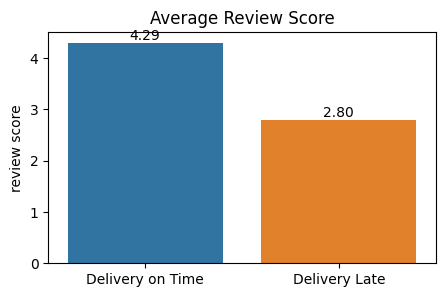

In [39]:
review_score = delivered_orders[['order_id','customer_delivery_perf','median_review_score']].drop_duplicates()

#create pivot table to get the avg review score of in time delivered orders vs late deliver
review_score = review_score.pivot_table(index='customer_delivery_perf', values='median_review_score', aggfunc='mean')
review_score = review_score.sort_values(by=['median_review_score'], ascending=False)

# present data to chart:
fig, ax = plt.subplots(1,1, figsize=(5,3))
ax = sns.barplot(x=review_score.index, y='median_review_score', data=review_score)
ax.set(title="Average Review Score", xlabel=None, ylabel="review score")
for container in ax.containers:
        ax.bar_label(container, labels=[f'{x:,.2f}' for x in container.datavalues])

Delivery On Time Get higher review scores than delivery late.

### 2.1.7 Customers & Sellers Location

In [4]:
geolocation = pd.read_csv('brazilian-ecommerce/olist_geolocation_dataset.csv')
customers = pd.read_csv('brazilian-ecommerce/olist_customers_dataset.csv')
sellers = pd.read_csv('brazilian-ecommerce/olist_sellers_dataset.csv')

geolocation = geolocation.rename(columns={"geolocation_zip_code_prefix": "zip_code_prefix"})
sellers = sellers.rename(columns={"seller_zip_code_prefix": "zip_code_prefix"})
customers = customers.rename(columns={"customer_zip_code_prefix": "zip_code_prefix"})

sellers = pd.merge(sellers, geolocation[['zip_code_prefix','geolocation_lat','geolocation_lng']], on ='zip_code_prefix')
sellers = sellers.drop_duplicates(subset ="seller_id", keep = 'last') 

customers = pd.merge(customers, geolocation[['zip_code_prefix','geolocation_lat','geolocation_lng']], on ='zip_code_prefix')
customers = customers.drop_duplicates(subset ="customer_id", keep = 'last') 

In [3]:
world = geopandas.read_file(geopandas.datasets.get_path("naturalearth_lowres"))
brazil = world[world["name"] == "Brazil"]

In [9]:
states = geolocation['geolocation_state'].unique()
rgb_colors = matplotlib.cm.rainbow(np.linspace(0, 1, len(states)))
hexa_colors = []
for i in range(len(rgb_colors)):
    hexa_colors.append(matplotlib.colors.rgb2hex(rgb_colors[i]))

state_colors = pd.DataFrame({'state': states, 'color': hexa_colors})

In [10]:
customers = pd.merge(customers, state_colors, left_on ='customer_state', right_on='state')
geometry = [Point(xy) for xy in zip(customers['geolocation_lng'], customers['geolocation_lat'])]
gdf = GeoDataFrame(geometry=geometry)

<AxesSubplot:>

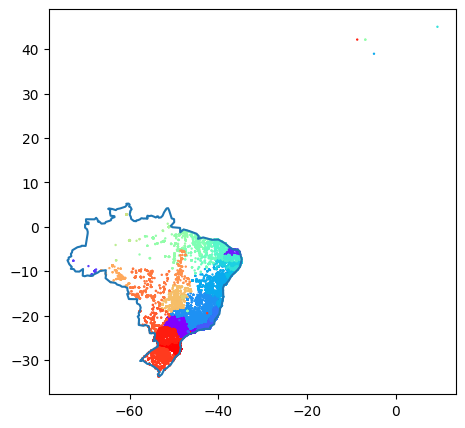

In [12]:
gdf.plot(ax=brazil.boundary.plot(figsize=(10, 5)), marker='o', color=customers['color'], markersize=0.5)

In [14]:
sellers = pd.merge(sellers, state_colors, left_on ='seller_state', right_on='state')
geometry2 = [Point(xy) for xy in zip(sellers['geolocation_lng'], sellers['geolocation_lat'])]
gdf2 = GeoDataFrame(geometry=geometry2)

<AxesSubplot:>

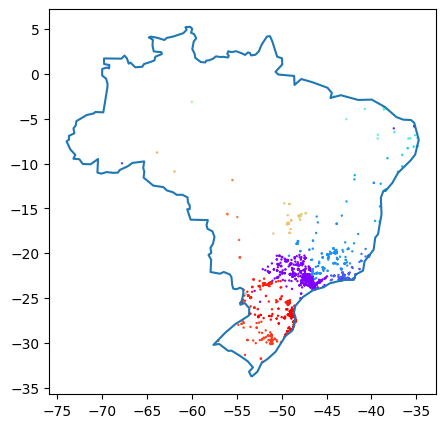

In [16]:
gdf2.plot(ax=brazil.boundary.plot(figsize=(10, 5)), marker='o', color=sellers['color'], markersize=0.5)

Olist’s customers are mostly in the eastern of Brazil

Olist’s sellers are mostly in the southeast. 

=> Logistic paths are mostly from center to eastern.


### 2.1.9 Delivery Time & AOV Per State

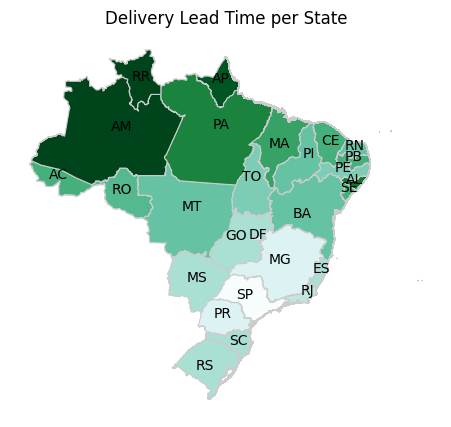

In [33]:
mv_dup_orders_cat = delivered_orders[['order_id','delivery_lead_time', 'customer_state']].drop_duplicates(keep='first')
mv_dup_orders_cat = mv_dup_orders_cat.groupby(['customer_state']).agg({'delivery_lead_time': 'median'})
bra_map_df = geopandas.read_file('brazilian-ecommerce/BRA_adm1.shp')
bra_map_raw = geopandas.read_file('brazilian-ecommerce/BRA_adm1.csv')

bra_map_df['coords'] = bra_map_df['geometry'].apply(lambda x: x.representative_point().coords[:])
bra_map_df['coords'] = [coords[0] for coords in bra_map_df['coords']]

# delivery_by_state_df = pd.DataFrame({'state_code': bra_map_raw['CODE_1'], 'value': np.random.randint(100, 10000, size=len(bra_map_df))})
bra_map_raw = pd.merge(bra_map_raw[['NAME_1', 'CODE_1']], mv_dup_orders_cat, left_on='CODE_1', right_on='customer_state')
merged_df = pd.merge(bra_map_df, bra_map_raw, on='NAME_1')

# set a variable that will call whatever column we want to visualise on the map
variable = 'delivery_lead_time'

# set the range for the choropleth
vmin, vmax = mv_dup_orders_cat[variable].min(), mv_dup_orders_cat[variable].max()

# create figure and axes for Matplotlib
fig2, ax2 = plt.subplots(1, figsize=(10, 5))

ax2.axis('off')
# add a title
ax2.set_title('Delivery Lead Time per State', fontdict={'fontsize': '12', 'fontweight' : '3'})


merged_df.plot(column=variable, cmap='BuGn', linewidth=0.8, ax=ax2, edgecolor='0.8')
for idx, row in merged_df.iterrows():   
    plt.annotate(text=row['CODE_1'], xy=row['coords'], horizontalalignment='center', color='black')


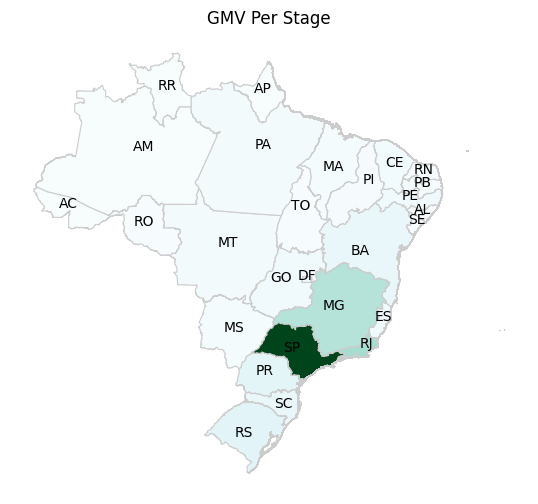

In [38]:
mv_dup_orders_re = delivered_orders[['order_id', 'price', 'customer_state']].drop_duplicates(keep='first')
mv_dup_orders_re = mv_dup_orders_re.groupby(['customer_state']).agg({'price': 'sum'})

bra_map_raw = pd.merge(bra_map_raw[['NAME_1', 'CODE_1']], mv_dup_orders_re, left_on='CODE_1', right_on='customer_state')
merged_df = pd.merge(bra_map_df, bra_map_raw, on='NAME_1')

variable = 'price'

vmin, vmax = mv_dup_orders_re[variable].min(), mv_dup_orders_re[variable].max()

fig2, ax2 = plt.subplots(1, figsize=(10, 6))

ax2.axis('off')
ax2.set_title('GMV Per Stage', fontdict={'fontsize': '12', 'fontweight' : '3'})

merged_df.plot(column=variable, cmap='BuGn', linewidth=0.8, ax=ax2, edgecolor='0.8')
for idx, row in merged_df.iterrows():   
    plt.annotate(text=row['CODE_1'], xy=row['coords'], horizontalalignment='center', color='black')


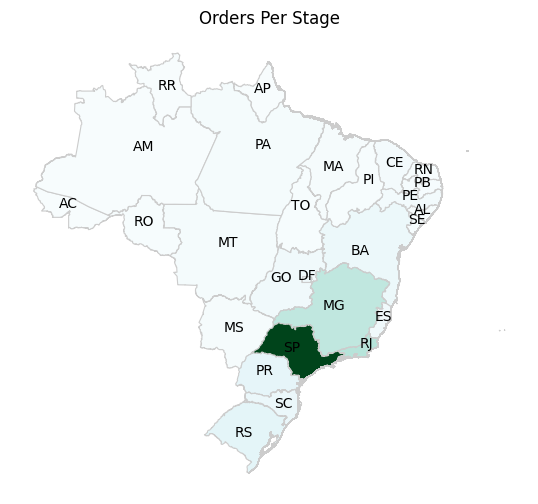

In [42]:
mv_dup_orders_re = delivered_orders[['order_id', 'price', 'customer_state']].drop_duplicates(keep='first')
mv_dup_orders_re = mv_dup_orders_re.groupby(['customer_state']).agg({'order_id': 'nunique'})

bra_map_raw = pd.merge(bra_map_raw[['NAME_1', 'CODE_1']], mv_dup_orders_re, left_on='CODE_1', right_on='customer_state')
merged_df = pd.merge(bra_map_df, bra_map_raw, on='NAME_1')

variable = 'order_id'

vmin, vmax = mv_dup_orders_re[variable].min(), mv_dup_orders_re[variable].max()

fig2, ax2 = plt.subplots(1, figsize=(10, 6))

ax2.axis('off')
ax2.set_title('Orders Per Stage', fontdict={'fontsize': '12', 'fontweight' : '3'})

merged_df.plot(column=variable, cmap='BuGn', linewidth=0.8, ax=ax2, edgecolor='0.8')
for idx, row in merged_df.iterrows():   
    plt.annotate(text=row['CODE_1'], xy=row['coords'], horizontalalignment='center', color='black')
